#Install the required packages and depedencies

In [2]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
!pip install -q condacolab

import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [4]:
# Install PyTorch
!conda install pytorch=1.6.0 torchvision cudatoolkit=10.1 -c pytorch
# Install MMCV
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.6/index.html

Solving environment: \ | / - \ | / - \ | / - \ WARNING conda.core.solve:_add_specs(649): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
| / - \ | / - \ | / done

# All requested packages already installed.

Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.6/index.html


In [5]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 6531, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 6531 (delta 3), reused 7 (delta 1), pack-reused 6509
Receiving objects: 100% (6531/6531), 12.64 MiB | 10.53 MiB/s, done.
Resolving deltas: 100% (4857/4857), done.
/content/mmsegmentation
Obtaining file:///content/mmsegmentation
  Running setup.py develop for mmsegmentation


In [6]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.6.0 True
0.22.1


#Declare data directories and upload the data

In [7]:
#declare global variables
root_dir = '/content/drive/MyDrive/Colab Notebooks/AI6126_ACV/Face_Parsing/'
data_root_dir = '/content/drive/MyDrive/Colab Notebooks/AI6126_ACV/Face_Parsing/data/'
work_dirs = '/content/drive/MyDrive/Colab Notebooks/AI6126_ACV/Face_Parsing/work_dirs'
dataset= "CelebAMaskHQ"

classes = ('background', 'skin', 'nose', 'eye_g', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'l_ear', 'r_ear', 'mouth', 'u_lip', 'l_lip', 'hair', 'hat', 'ear_r', 'neck_l', 'neck', 'cloth')
palette = [[0, 0, 0], [204, 0, 0], [76, 153, 0], [204, 204, 0], [51, 51, 255], [204, 0, 204], 
           [0, 255, 255], [255, 204, 204], [102, 51, 0], [255, 0, 0], [102, 204, 0], [255, 255, 0], 
           [0, 0, 153], [0, 0, 204], [255, 51, 153], [0, 204, 204], [0, 51, 0], [255, 153, 51], [0, 204, 0]]

In [8]:
import os

#check file counts
train_imgs= data_root_dir + dataset+'/train/train_image'
val_imgs= data_root_dir + dataset +'/val/val_image'
train_ann= data_root_dir + dataset+'/train/train_mask'
val_ann= data_root_dir + dataset+'/val/val_mask'

#print the file count
print(len(os.listdir(train_imgs)))
print(len(os.listdir(val_imgs)))
print(len(os.listdir(train_ann)))
print(len(os.listdir(val_ann)))

5000
1000
5000
1000


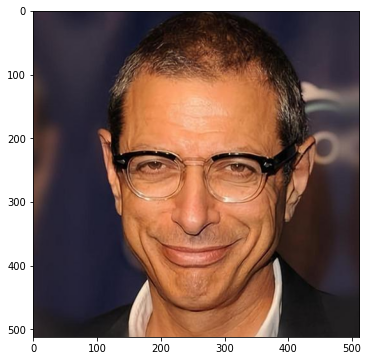

In [9]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt
import glob

PATH_TO_TRAIN_IMAGES_DIR= data_root_dir+dataset+"/train/train_image"
PATH_TO_LABEL_IMAGES_DIR= data_root_dir+dataset+"/train/train_mask"
TRAIN_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TRAIN_IMAGES_DIR, "*.jpg"))
LABEL_PATHS= glob.glob(os.path.join(PATH_TO_LABEL_IMAGES_DIR, "*.png"))

TRAIN_IMAGE_PATHS.sort()
LABEL_PATHS.sort()

img = mmcv.imread(TRAIN_IMAGE_PATHS[0])
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

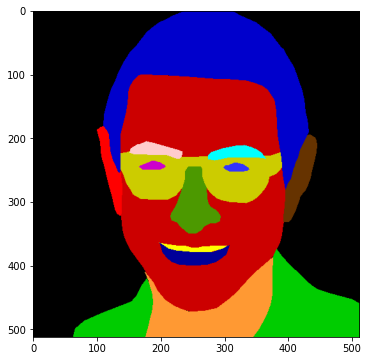

In [10]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
import os.path as osp
import numpy as np
from PIL import Image

img = Image.open(LABEL_PATHS[0])
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

plt.show()

In [11]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class CelebAMaskDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)
    assert osp.exists(self.img_dir)

#Create and modify the config file

In [15]:
from mmcv import Config
cfg = Config.fromfile('/content/drive/MyDrive/Colab Notebooks/AI6126_ACV/Face_Parsing/config.py')

In [16]:
from mmseg.apis import set_random_seed

#add CLASSES and PALETTE to checkpoint
cfg.checkpoint_config.meta = dict(CLASSES=classes, PALETTE=palette)

cfg.norm_cfg = dict(type='BN', requires_grad=True)

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.work_dir = work_dirs

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='DepthwiseSeparableASPPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        dilations=(1, 12, 24, 36),
        c1_in_channels=256,
        c1_channels=48,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        sampler=dict(type='OHEMPixelSampler', thresh=0.7, min_kept=100000),
        loss_decode=dict(
            type='CrossEntropyLoss',
            use_sigmoid=False,
            loss_w

In [17]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

import torch
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2022-03-25 06:43:13,933 - mmseg - INFO - Loaded 5000 images
/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
2022-03-25 06:43:15,477 - mmseg - INFO - Loaded 1000 images
2022-03-25 06:43:15,478 - mmseg - INFO - load checkpoint from local path: /content/drive/MyDrive/Colab Notebooks/AI6126_ACV/Face_Parsing/work_dirs/iter_20000.pth
2022-03-25 06:43:21,644 - mmseg - INFO - resumed from epoch: 1, iter 19999
2022-03-25 06:43:21,646 - mmseg - INFO - Start running, host: root@4b1ccf76cba4, work_dir: /content/drive/MyDrive/Colab Notebooks/AI6126_ACV/Face_Parsing/work_dirs
2022-03-25 06:43:21,647 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) CyclicLrUpdaterHook                
(HIGH        ) CyclicMomentumUpdaterHook          
(NORMAL      ) CheckpointHook                     
(LOW  

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1000/1000, 9.4 task/s, elapsed: 106s, ETA:     0s

2022-03-25 06:45:13,379 - mmseg - INFO - per class results:
2022-03-25 06:45:13,384 - mmseg - INFO - 
+------------+-------+-------+-------+
|   Class    |  IoU  |  Acc  |  Dice |
+------------+-------+-------+-------+
| background | 91.22 | 95.71 | 95.41 |
|    skin    | 92.21 | 95.78 | 95.95 |
|    nose    | 87.84 | 94.04 | 93.52 |
|   eye_g    | 76.37 | 91.57 |  86.6 |
|   l_eye    |  79.6 | 90.85 | 88.64 |
|   r_eye    | 79.54 | 90.55 |  88.6 |
|   l_brow   | 74.26 | 86.94 | 85.23 |
|   r_brow   | 73.18 | 86.09 | 84.52 |
|   l_ear    | 74.45 | 87.62 | 85.35 |
|   r_ear    | 73.68 | 85.49 | 84.85 |
|   mouth    | 83.46 | 90.32 | 90.99 |
|   u_lip    | 78.54 | 89.95 | 87.98 |
|   l_lip    | 81.55 | 91.73 | 89.84 |
|    hair    | 89.63 | 94.44 | 94.53 |
|    hat     | 67.89 | 78.13 | 80.87 |
|   ear_r    | 45.97 | 69.32 | 62.98 |
|   neck_l   |  7.68 | 10.82 | 14.26 |
|    neck    | 81.47 | 89.83 | 89.79 |
|   cloth    |  71.5 | 81.26 | 83.38 |
+------------+-------+-------+-------+
2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1000/1000, 9.5 task/s, elapsed: 105s, ETA:     0s

2022-03-25 07:35:58,437 - mmseg - INFO - per class results:
2022-03-25 07:35:58,440 - mmseg - INFO - 
+------------+-------+-------+-------+
|   Class    |  IoU  |  Acc  |  Dice |
+------------+-------+-------+-------+
| background | 90.63 | 94.91 | 95.09 |
|    skin    | 91.89 | 95.51 | 95.77 |
|    nose    | 86.97 | 90.71 | 93.03 |
|   eye_g    | 76.27 | 91.07 | 86.54 |
|   l_eye    | 79.27 | 91.11 | 88.44 |
|   r_eye    | 79.68 | 90.02 | 88.69 |
|   l_brow   | 73.74 | 84.15 | 84.89 |
|   r_brow   | 72.53 | 84.35 | 84.08 |
|   l_ear    | 74.39 | 84.64 | 85.31 |
|   r_ear    | 70.73 | 89.46 | 82.86 |
|   mouth    | 82.96 | 90.66 | 90.69 |
|   u_lip    | 78.78 | 87.45 | 88.13 |
|   l_lip    | 81.04 | 89.39 | 89.53 |
|    hair    | 88.94 | 95.03 | 94.15 |
|    hat     | 63.72 |  78.2 | 77.84 |
|   ear_r    | 44.07 |  60.6 | 61.17 |
|   neck_l   | 10.22 | 14.46 | 18.54 |
|    neck    |  80.6 | 90.57 | 89.26 |
|   cloth    | 69.64 |  76.7 |  82.1 |
+------------+-------+-------+-------+
2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1000/1000, 9.5 task/s, elapsed: 105s, ETA:     0s

2022-03-25 08:26:48,034 - mmseg - INFO - per class results:
2022-03-25 08:26:48,037 - mmseg - INFO - 
+------------+-------+-------+-------+
|   Class    |  IoU  |  Acc  |  Dice |
+------------+-------+-------+-------+
| background | 91.26 | 94.94 | 95.43 |
|    skin    | 92.26 |  95.9 | 95.97 |
|    nose    | 87.97 | 93.16 |  93.6 |
|   eye_g    | 77.29 | 88.02 | 87.19 |
|   l_eye    | 79.97 | 89.87 | 88.87 |
|   r_eye    | 79.53 | 90.05 |  88.6 |
|   l_brow   | 74.36 | 85.89 | 85.29 |
|   r_brow   | 72.97 | 86.23 | 84.37 |
|   l_ear    | 74.75 | 83.91 | 85.55 |
|   r_ear    |  73.4 | 83.41 | 84.66 |
|   mouth    | 83.51 | 90.04 | 91.02 |
|   u_lip    | 79.36 | 88.19 | 88.49 |
|   l_lip    | 81.56 | 89.42 | 89.85 |
|    hair    | 89.71 | 95.05 | 94.58 |
|    hat     | 66.76 | 78.23 | 80.07 |
|   ear_r    |  46.5 | 62.13 | 63.48 |
|   neck_l   |  8.43 | 12.34 | 15.54 |
|    neck    | 81.61 | 89.37 | 89.87 |
|   cloth    | 71.47 |  85.2 | 83.36 |
+------------+-------+-------+-------+
2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1000/1000, 9.5 task/s, elapsed: 105s, ETA:     0s

2022-03-25 09:17:36,566 - mmseg - INFO - per class results:
2022-03-25 09:17:36,570 - mmseg - INFO - 
+------------+-------+-------+-------+
|   Class    |  IoU  |  Acc  |  Dice |
+------------+-------+-------+-------+
| background | 91.34 | 95.27 | 95.47 |
|    skin    | 92.31 | 96.06 |  96.0 |
|    nose    | 87.83 | 92.58 | 93.52 |
|   eye_g    | 76.67 | 91.05 |  86.8 |
|   l_eye    | 80.48 | 89.94 | 89.19 |
|   r_eye    | 80.09 |  90.6 | 88.94 |
|   l_brow   |  74.6 | 86.84 | 85.45 |
|   r_brow   | 73.15 | 87.14 |  84.5 |
|   l_ear    | 74.75 | 84.62 | 85.55 |
|   r_ear    | 73.94 | 83.84 | 85.02 |
|   mouth    | 83.84 | 90.78 | 91.21 |
|   u_lip    | 79.53 | 88.82 |  88.6 |
|   l_lip    |  82.0 | 90.37 | 90.11 |
|    hair    | 89.82 | 94.84 | 94.64 |
|    hat     | 68.34 | 82.22 | 81.19 |
|   ear_r    | 45.42 | 54.99 | 62.47 |
|   neck_l   |  7.78 | 12.43 | 14.44 |
|    neck    | 81.66 | 90.35 |  89.9 |
|   cloth    | 71.99 | 82.95 | 83.72 |
+------------+-------+-------+-------+
2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1000/1000, 9.5 task/s, elapsed: 105s, ETA:     0s

2022-03-25 10:08:27,321 - mmseg - INFO - per class results:
2022-03-25 10:08:27,325 - mmseg - INFO - 
+------------+-------+-------+-------+
|   Class    |  IoU  |  Acc  |  Dice |
+------------+-------+-------+-------+
| background | 91.34 | 95.47 | 95.48 |
|    skin    | 92.32 | 95.82 | 96.01 |
|    nose    |  88.0 | 93.59 | 93.62 |
|   eye_g    | 77.37 | 91.14 | 87.24 |
|   l_eye    | 80.27 | 89.72 | 89.05 |
|   r_eye    |  80.1 | 89.14 | 88.95 |
|   l_brow   | 74.73 | 86.02 | 85.54 |
|   r_brow   | 73.38 | 84.64 | 84.65 |
|   l_ear    | 74.88 | 83.96 | 85.64 |
|   r_ear    | 73.65 | 82.83 | 84.83 |
|   mouth    |  83.9 | 90.25 | 91.24 |
|   u_lip    | 79.64 | 88.93 | 88.67 |
|   l_lip    | 82.16 | 90.76 | 90.21 |
|    hair    | 89.85 | 95.09 | 94.66 |
|    hat     | 68.97 | 80.85 | 81.63 |
|   ear_r    |  47.3 | 60.89 | 64.22 |
|   neck_l   |  9.55 |  14.4 | 17.43 |
|    neck    | 81.72 | 89.83 | 89.94 |
|   cloth    | 71.71 | 81.98 | 83.53 |
+------------+-------+-------+-------+
2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1000/1000, 9.5 task/s, elapsed: 105s, ETA:     0s

2022-03-25 10:59:15,822 - mmseg - INFO - per class results:
2022-03-25 10:59:15,825 - mmseg - INFO - 
+------------+-------+-------+-------+
|   Class    |  IoU  |  Acc  |  Dice |
+------------+-------+-------+-------+
| background | 91.41 | 95.68 | 95.51 |
|    skin    | 92.33 | 95.94 | 96.01 |
|    nose    | 88.03 |  93.6 | 93.63 |
|   eye_g    | 77.08 | 91.48 | 87.05 |
|   l_eye    | 80.32 | 89.71 | 89.08 |
|   r_eye    | 80.15 | 89.16 | 88.98 |
|   l_brow   | 74.72 | 86.72 | 85.53 |
|   r_brow   |  73.4 | 85.32 | 84.66 |
|   l_ear    | 75.12 |  85.2 | 85.79 |
|   r_ear    |  74.0 | 84.65 | 85.06 |
|   mouth    | 83.95 | 90.33 | 91.27 |
|   u_lip    | 79.64 | 89.17 | 88.66 |
|   l_lip    | 82.04 | 90.57 | 90.13 |
|    hair    | 89.88 |  95.0 | 94.67 |
|    hat     | 69.08 | 79.87 | 81.72 |
|   ear_r    | 47.09 | 60.11 | 64.03 |
|   neck_l   |  7.83 | 11.18 | 14.52 |
|    neck    | 81.67 | 89.71 | 89.91 |
|   cloth    |  72.0 | 81.09 | 83.72 |
+------------+-------+-------+-------+
2

#Inference with trained model

In [ ]:
# Val Image
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot

config_file = '/content/drive/MyDrive/Colab Notebooks/AI6126_ACV/Face_Parsing/config.py'
checkpoint = root_dir + '/work_dirs/iter_20000.pth' #checkpoint path

# build the model from a config file and a checkpoint file
#model = build_segmentor(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model = init_segmentor(config_file, checkpoint, device = 'cuda:0')

#PATH_TO_VAL_IMAGES_DIR = data_root+dataset+"/val/val_image"
#PATH_TO_LABEL_IMAGES_DIR= data_root+dataset+"/val/val_mask"
#VAL_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_VAL_IMAGES_DIR, "*.jpg"))
#LABEL_PATHS= glob.glob(os.path.join(PATH_TO_LABEL_IMAGES_DIR, "*.png"))
#VAL_RESULT_PATHS = data_root+dataset+"/val/val_result/"

#VAL_IMAGE_PATHS.sort()
#LABEL_PATHS.sort()

#print(len(VAL_IMAGE_PATHS))


for i in range (0, 1000):
  img = mmcv.imread(data_root_dir+dataset+"/val/val_image/"+str(i) + '.jpg')
  #print(data_root+dataset+"/val/val_image/"+str(i) + '.jpg')
  result = inference_segmentor(model, img)

  image_file_name= data_root_dir+dataset+"/val/val_result/"+str(i) + '.png'
  result_path = data_root_dir+dataset+"/val/val_result/"
  result_name = str(i) + '.png'
  test_result = mmcv.imwrite(result[0], image_file_name)
  
  print("saving "+str(i))
  i= i+1

In [20]:
# Test Image
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot

config_file = '/content/drive/MyDrive/Colab Notebooks/AI6126_ACV/Face_Parsing/config.py'
checkpoint = root_dir + '/work_dirs/iter_28000.pth' #checkpoint path
model = init_segmentor(config_file, checkpoint, device = 'cuda:0')

for i in range (0, 1000):
  img = mmcv.imread(data_root_dir+dataset+"/test/test_image/"+str(i) + '.jpg')
  print(data_root_dir+dataset+"/test/test_image/"+str(i) + '.jpg')
  result = inference_segmentor(model, img)

  image_file_name= data_root_dir+dataset+"/test/test_result/"+str(i) + '.png'
  result_path = data_root_dir+dataset+"/test/test_result/"
  result_name = str(i) + '.png'
  test_result = mmcv.imwrite(result[0], image_file_name)
  
  #print("saving "+str(i))
  i= i+1

load checkpoint from local path: /content/drive/MyDrive/Colab Notebooks/AI6126_ACV/Face_Parsing//work_dirs/iter_28000.pth
/content/drive/MyDrive/Colab Notebooks/AI6126_ACV/Face_Parsing/data/CelebAMaskHQ/test/test_image/0.jpg
/content/drive/MyDrive/Colab Notebooks/AI6126_ACV/Face_Parsing/data/CelebAMaskHQ/test/test_image/1.jpg
/content/drive/MyDrive/Colab Notebooks/AI6126_ACV/Face_Parsing/data/CelebAMaskHQ/test/test_image/2.jpg
/content/drive/MyDrive/Colab Notebooks/AI6126_ACV/Face_Parsing/data/CelebAMaskHQ/test/test_image/3.jpg
/content/drive/MyDrive/Colab Notebooks/AI6126_ACV/Face_Parsing/data/CelebAMaskHQ/test/test_image/4.jpg
/content/drive/MyDrive/Colab Notebooks/AI6126_ACV/Face_Parsing/data/CelebAMaskHQ/test/test_image/5.jpg
/content/drive/MyDrive/Colab Notebooks/AI6126_ACV/Face_Parsing/data/CelebAMaskHQ/test/test_image/6.jpg
/content/drive/MyDrive/Colab Notebooks/AI6126_ACV/Face_Parsing/data/CelebAMaskHQ/test/test_image/7.jpg
/content/drive/MyDrive/Colab Notebooks/AI6126_ACV/Face

In [23]:
parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(parameters)

43589878


In [24]:
!nvidia-smi

Fri Mar 25 12:09:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    29W /  70W |   9288MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------